# Sequences of Churn Models via Multi-Task Learning with Random Forests

Churn prediction is a common task for many of us.

Often, we're interested in training a sequence of churn models for a variety of look-ahead windows.  For example, we might want to compute the probability of churn for a customer within the next 1, 3, 6, and 12 months.

A good constraint to enforce on any machine learning system is that the outputs should accord with common sense.  Unfortunately, some approaches violate the common sense constraint that e.g. the likelihood of a customer churning within the next 12 months is greater than the likelihood of them churning within the next 6 months.  Let's call this constraint "the ordering constraint"

Enforcing this constraint can be tricky, but there are ways to get a model to do it for you (or get you very close to it) with little effort.

One method is to make use of multi-task learning to force the your algorithm to make use of shared model structure.  Sharing model structure will naturally produce predictions with more commonalities and more direct interrelatedness than training a series of independent models.

In particular, a Random Forest has a nice property that can be easily demonstrated that when properly implemented and fit using multi-task learning, it has a 100% guarantee of satisfying the ordering constraint for a series of churn predictions.



## The Mathy Bit

(Feel free to skip this explanation on first pass if you're mostly interested in the results)

In order to see why, let's use a very simple example.  

Imagine we have constructed a target matrix Y with the following description:
- each row represents a single customer
- each row contains binary indicators of whether churn has occurred for that specific customer within specific time periods 
- each column represents a number of months worth of look-ahead past the modeling horizon during which we'll evaluate whether a customer has churned.  
    Ex: the first column tells us whether the customer has churned within 1 month of the modeling horizon.  The 3rd column tells us whether the customer has churned within 3 months of the modeling horizon.
    
For example, we could have a churn matrix that looks like this:

In [276]:
'''
            1M, 2M, 3M
customer A: 0,  0,  1
customer B: 1,  1,  1
customer C: 0,  1,  1
'''

'\n            1M, 2M, 3M\ncustomer A: 0,  0,  1\ncustomer B: 1,  1,  1\ncustomer C: 0,  1,  1\n'

From this target matrix, we can see that customer A did not churn within the first 1 or 2 months, but did churn within the first 3 months.  Customer B churned in month 1, and so would also be considered to have churned within the first 2 months and also first 3 months. 

Now, imagine we have a set of features we can use to craft a decision tree to model the likelihood of churn.

When we use multi-task learning, the learning algorithm will fit a single decision tree to best model all targets simultaneously. For example, you might perform a single split of the above data and get a tree structure like below:

Node 1: [customer A]
Node 2: [customer B, customer C]

Since the prediction at a leaf node is the average of the target values for the rows that are propagated to that node, and we're using the same tree for every target, we'll have the following results for this example:


Churn Scores:

        1M,  2M,  3M
Node 1: 0.0, 0.0, 1.0
Node 2: 0.5, 1.0, 1.0


Note that the churn scores are in ascending order for samples which land in a given node.  It's easy to prove that this will always be the case given the fact that for all samples, the churn indicator for any given sample for a longer horizon window is always greater than or equal to the churn indicator for shorter horizon windows.  Therefore, the average of the churn indicators for a longer horizon window will always be greater than or equal to the average of churn indicators for a shorter horizon window for the set of samples which lands in a given node.

To generalize to a random forest, note that a random forest is again an average over numbers with similar properties.  When we compute the score for a single sample, we're averaging together a bunch of individual decision tree scores which already satisfy the ordering condition. I.e. since for each N-month score and each M-month score with N>M we have score_n_months >= score_m_months, then the overall forest output satisfies mean(all score_n_months) >= mean(all score_m_months), so the overall forest also satisfies the ordering condition.

Now to be thorough, this only holds if we use the same exact set of samples to compute the node values for a given sequence of target horizons.  If for a given node, we compute e.g. the 3M and 2M node weights using different subsamples of the data (due to subsampling some RF algos may do), then the ordering constraint won't necessarily be satisfied.  Because of this, the exact details of the Random Forest implementation matter.  For the scikit-learn implementation, I believe the subsampling is global across all targets on each splitting iteration, so the ordering constraint should be guaranteed to hold. 


# Experiments

Let's finally take a look at some code

In [102]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import precision_recall_curve

import random

# Toy Data Generation

To generate toy data for experiments, we use the following process:

- for each sample, generate a base monthly churn probability.  
    - For example, for a given customer - it might be 1%.  This would mean that every month, there is a 1% chance of that customer churning.
- this defines a distribution of churn events per row of data; in order to generate the Y matrix, sample from this distribution for each row of data
- if a churn event occurs in a given month, assign a positive indicator
- once a churn event occurs, all subsequent churn indicators are set to positive as well to indicate that the customer has already churned within the timeframe.

This will generate a target matrix Y similar to the one used in the example above.

In order to make this a modeling problem, the base monthly churn probabilitity needs to be a function of some features the model has access to.  Generate this monthly churn probability using a regression dataset + scaling and offsetting the target followed by a logistic transform.

Scale and offset parameters were chosen to yield a somewhat realistic looking distribution of churn behavior.

In [266]:
def generate_toy_dataset(n_train):
    
    def churn_vec(p, n_months):
        churned = False
        for i in range(n_months):
            churned = churned or random.random() < p
            yield churned
    
    def churn_df(ps, n_months=12):
        CM = np.asarray([list(churn_vec(p, n_months)) for p in ps]).astype(int)
        df = pd.DataFrame(data=CM, columns=[f'churned_{n:02d}M' for n in range(1, n_months+1)])
        return df
    
    # Generating an unbalanced dataset
    X, y = make_regression(
        n_samples=n_train,
        n_features=30,
        n_informative=5,
        effective_rank=12,
        tail_strength=0.5,
        noise=0.1,
        random_state=42
    )
    df = pd.DataFrame(X)
    df.columns = df.columns.astype(str)
    features = df.columns
    
    y -= y.mean()
    y /= y.std()
    
    df['p_monthly'] = 1 / (1+np.exp(6 - y/2 ))
    df = pd.concat([df, churn_df(df['p_monthly'])], axis=1)
    targets = df.filter(like='churned').columns

    return df, features, targets

df, features, targets = generate_toy_dataset(n_train=50000)

The monthly churn probability is distributed as below.  Note that the mean monthly churn probability for this toy dataset is about 1/4%.  That is, on average - 1/4% of customers will have a churn event.

<AxesSubplot:>

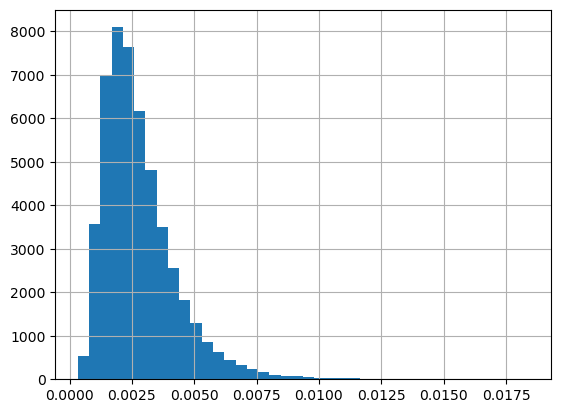

In [267]:
df['p_monthly'].hist(bins=40)

Below is a sample of the churn indicator matrix, Y. 

Note that once churn occurs, all subsequent values for that row are "1".

In [268]:
df[targets].sort_values(by='churned_12M', ascending=False).head()

,churned_01M,churned_02M,churned_03M,churned_04M,churned_05M,churned_06M,churned_07M,churned_08M,churned_09M,churned_10M,churned_11M,churned_12M
25408,0,0,1,1,1,1,1,1,1,1,1,1
5407,0,0,0,0,0,0,0,0,0,0,0,1
23475,0,0,0,0,0,0,1,1,1,1,1,1
47989,0,0,0,1,1,1,1,1,1,1,1,1
20320,0,0,0,0,0,0,0,0,1,1,1,1


The overall 12M churn rate is 3.3%.  That is, every year 3.3% of these customers will churn.

In [278]:
df['churned_12M'].mean()

0.0335

In [279]:
df['churned_12M'].sum()

1675

# Random Forest Multi-Task Learning

Let's perform multi-task learning with a random forest now. 

Fortunately for us, Scikit-Learn's random forest does this natively and it's very easy - so we're ready to go in just throwing this right in

We'll fit all 12 churn look-ahead windows (from 1 months to 12 months) simultaneously and take a look at the results.

P.shape (50000, 12)
Y.shape (50000, 12)


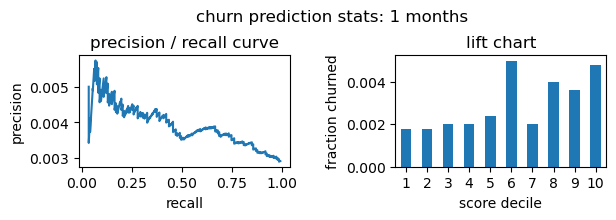

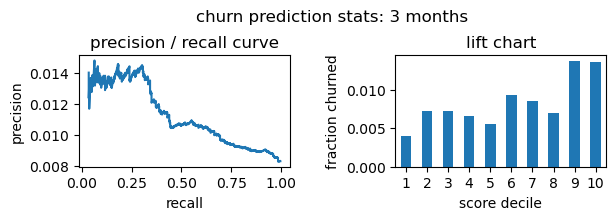

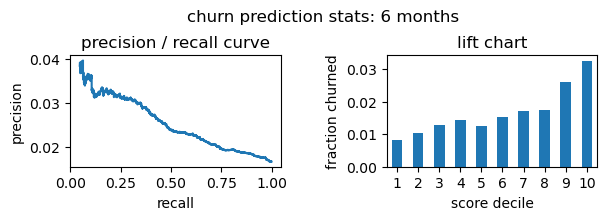

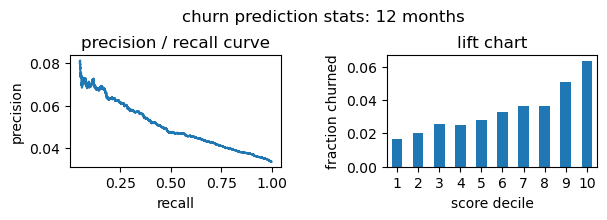

In [272]:
def random_forest():

    X = df[features]
    Y = df[targets].values
    
    model = RandomForestClassifier(n_jobs=8, n_estimators=128*2,
                                  oob_score=True, min_samples_leaf=len(df)//50, max_depth=6)
    
    model.fit(X, Y)
    P = model.oob_decision_function_[:, 1 :].squeeze()
    
    print('P.shape', P.shape)
    print('Y.shape', Y.shape)
    
    for month in [1, 3, 6, 12]:
        precision, recall, _ = precision_recall_curve(Y[:, month-1].ravel(), P[:, month-1].ravel())
        fig, ax = plt.subplots(1, 2, figsize=(6, 2))
        fig.tight_layout()
        plt.suptitle(f'churn prediction stats: {month} months')
        plt.subplots_adjust(top=0.75, wspace=0.5)
        plt.subplot(121)
        plt.title('precision / recall curve')
        plt.plot(recall[1:-1000], precision[1:-1000]) # compute precision / recall w at least 1000 samples
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.subplot(122)
        plt.title('lift chart')
        plt.ylabel('fraction churned')
        plt.xlabel('score decile')
        df.groupby(pd.qcut(P[:, month-1], 10, labels=range(1, 11)))[targets[month-1]].mean().plot(kind='bar', rot=0)
    
    
    return P
    
P = random_forest()

First to note is that the model seems be having an easier time modeling the 12 month churn likelihood than the 1 month.  This makes sense for several reasons.  One is that the class balance for 12 months is much less skewed than for 1 month; there's ~10x as many positive samples.  This helps both in terms of reducing data scarcity and making the problem generally easier.

In [273]:
df[targets].apply(lambda col:col.value_counts())

,churned_01M,churned_02M,churned_03M,churned_04M,churned_05M,churned_06M,churned_07M,churned_08M,churned_09M,churned_10M,churned_11M,churned_12M
0,49853,49714,49585,49450,49303,49165,49021,48899,48743,48607,48466,48325
1,147,286,415,550,697,835,979,1101,1257,1393,1534,1675


Next let's whether the predictions have the main desired property satisfaction of the ordering constraint: that the model predicts that the likelihood of churn within N months is greater than the the likelihood of churn within M months if N > M.

In [274]:
def check_sorted(X):
    is_sorted = [np.all(x==np.sort(x)) for x in X]
    print(np.mean(is_sorted))
check_sorted(P)

1.0


You can see that 100% of predictions are perfectly ordered. 

Let's look at that a different way by checking some rows of predictions and visually verifying that they increase monotonically

<AxesSubplot:title={'center':'sample of sequences of churn scores'}, ylabel='churn score'>

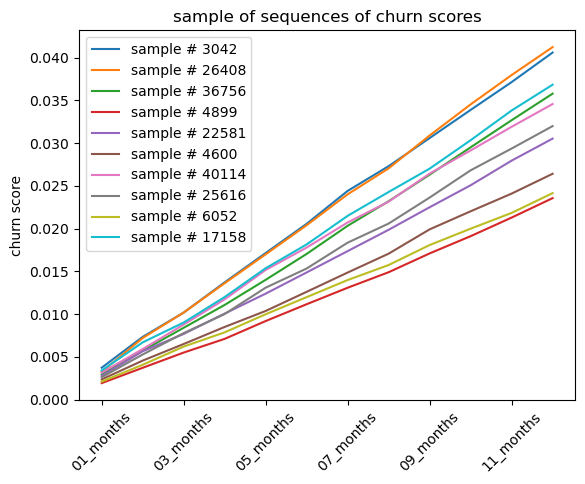

In [275]:
(pd.DataFrame(data=P, 
              columns=[f'{_:02d}_months' for _ in range(1, 13)], 
              index=[f'sample # {_}' for _ in range(len(P))])
   .sample(n=10).T
   .plot(title='sample of sequences of churn scores', rot=45, ylabel='churn score'))

# Conclusion and Follow-ups

So - if you've got a set of models that need to satisfy these constraints - you've got at least one technique you can use to enforce them.

There are other methods that can be used as well which may become the subject of future articles.


One caveat here: the Random Forest will not yield calibrated predictions.  So if you need probabilities - you'll have to perform a post-calibration step.

Thanks for reading, and happy modeling :) 


# NOTES TO SELF

# Experiments

- tune the model so it's good
- check the precision / recall curves and lift curves for 1, 3, 6, and 12 months
- compare data share to no data share - is the model better with sharing
- demonstrate that the predictions are ordered

# Illustrations

- explain the intuition behind why the predictions are guaranteed to be well ordered

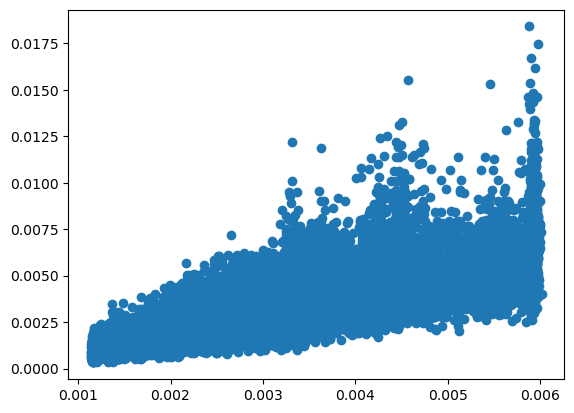

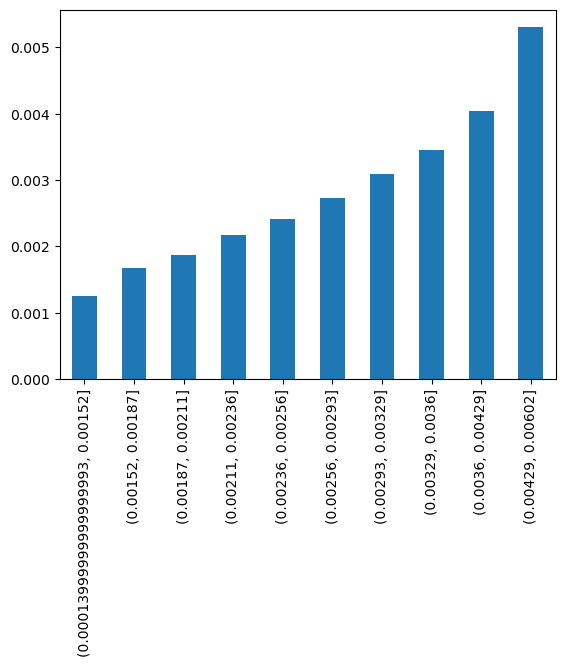

In [280]:
def test_basic_fit():
    X = df[features]
    y = df['p_monthly']
    
    model = RandomForestRegressor(n_jobs=8, n_estimators=128,
                                  oob_score=True, min_samples_leaf=len(df)//50, max_depth=6)
    
    P = model.fit(X, y).oob_prediction_
    
    plt.scatter(P, y)
    
    plt.figure()
    df.groupby(pd.qcut(P, 10))['p_monthly'].mean().plot(kind='bar')   
    
    
test_basic_fit()
    